<a href="https://colab.research.google.com/github/monicafar147/classification-predict-streamlit-template/blob/Preprocessing/climate_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Importing the modules

In [ ]:
# pip install contractions
# nltk.download('stopwords')

In [ ]:
import numpy as np 
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

# text preprocessing
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import Word
from wordcloud import WordCloud, STOPWORDS

# models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

## Importing the data

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/monicafar147/classification-predict-streamlit-template/master/climate-change-belief-analysis/test.csv")

In [ ]:
print("Train\n")
print(train.head(5))
print("\nTest")
print(test.head(5))

Train

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

Test
                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


# EDA

First we see if there are any repeats or Null values in the dataset


In [ ]:
# Checking that there is no repeats in the Data

unique = [i for i in train['tweetid'].unique()]
print("Number of unique values")
print(train['tweetid'].nunique())
print("\nTotal number of values")
print(len(train['tweetid']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
15819

Total number of values
15819

Number of null values:
sentiment    0
message      0
tweetid      0
dtype: int64


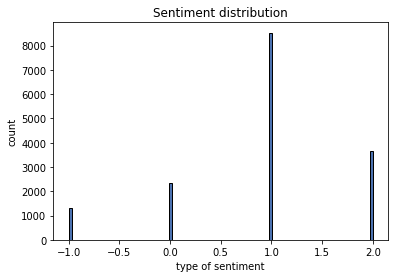

In [ ]:
# We plot a graph to see the sentiment distribution
plt.hist(train['sentiment'], bins = 100, edgecolor = 'k')
plt.xlabel('type of sentiment')
plt.ylabel('count')
plt.title('Sentiment distribution')
plt.show()

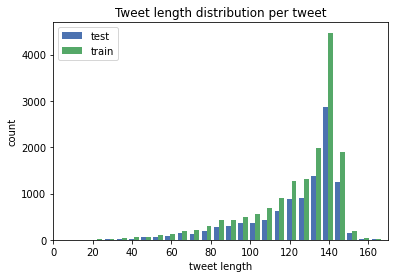

In [ ]:
# Explore the word count and tweet lengths
train['length'] = train['message'].astype(str).apply(len)
train['word_count'] = train['message'].apply(lambda x: len(str(x).split()))
test['length'] = test['message'].astype(str).apply(len)
test['word_count'] = test['message'].apply(lambda x: len(str(x).split()))

# Creating the plot
plt.hist([test['length'], train['length']], bins=100, label=['test', 'train'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

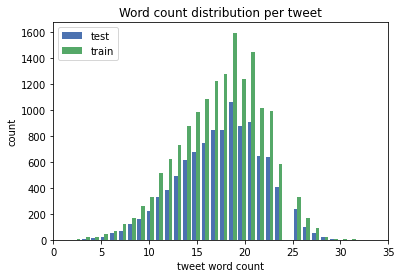

In [ ]:
plt.hist([test['word_count'], train['word_count']], bins=100, label=['test', 'train'])
plt.title('Word count distribution per tweet')
plt.xlabel('tweet word count')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,35])
plt.show()

Word cloud to see what the most popular words are in the dataset so we can better understand the data

In [ ]:
train['sentiment'].value_counts(normalize=True)

 1    0.539225
 2    0.230103
 0    0.148745
-1    0.081927
Name: sentiment, dtype: float64

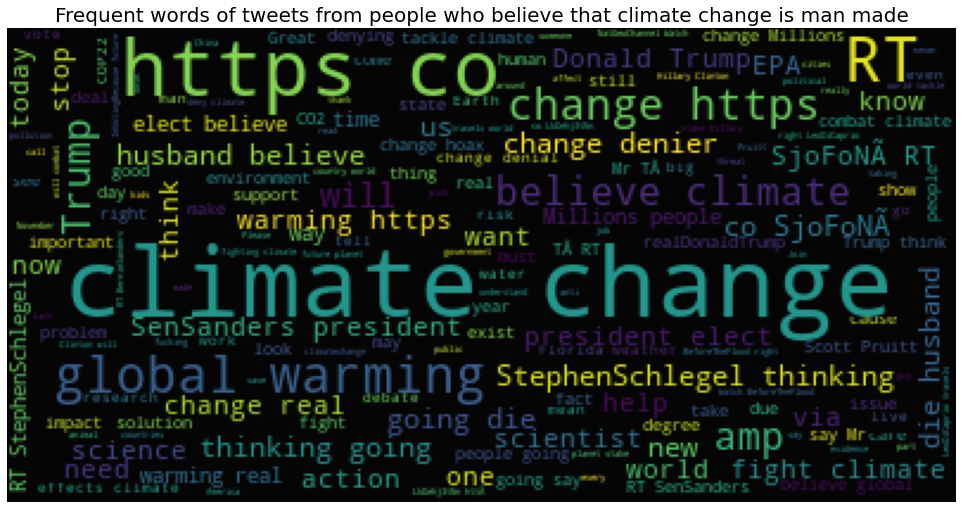

In [ ]:
rnd_comments = train[train['sentiment']==1].sample(n=2000)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comments))

plt.figure(figsize=(17,10))
plt.axis('off')
plt.title('Frequent words of tweets from people who believe that climate change is man made', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

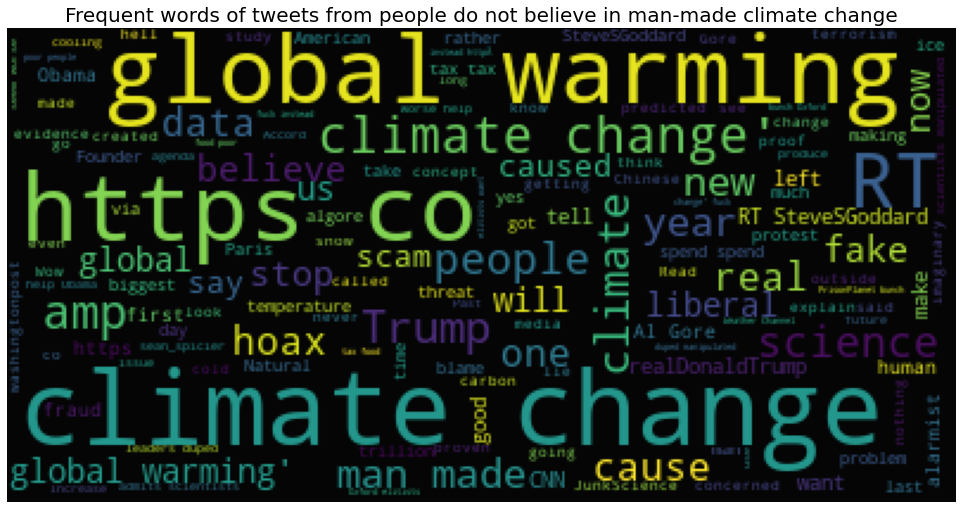

In [ ]:
rnd_comment = train[train['sentiment']==-1].sample(n=200)['message'].values
wc = WordCloud(background_color='black', max_words=2000, stopwords=STOPWORDS)
wc.generate(''.join(rnd_comment))

plt.figure(figsize=(17,10))
plt.axis('off')
plt.title('Frequent words of tweets from people do not believe in man-made climate change', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

# Data preprocessing
Combine the train and test data in order to do preprocessing on both datasets. This is essential to test the models being built. This step will also be useful for implementing the API.

Before preprocessing we need to ask ourseleves the following questions about this data:
1. does URL have impact on tweet sentiment?
2. does retweet have any impact on tweet sentiment?
3. does removing hashtags remove sentment?
4. contractions are a problem - removing doesn't -> does




Creating a function which will preprocess all of our data.


In [ ]:
def _preprocess(data):
  df = data.copy()

  # apply lowercase to data
  data['message'] = data['message'].apply(lambda word: ''.join(word.lower()))

  # function to remove contraction
  def remove_contraction(row):
    fixed = [contractions.fix(word) for word in row.split()]
    return ' '.join(map(str,fixed))

  # replace contractions
  df['message'] = np.vectorize(remove_contraction)(df['message'])

  # function to remove patterns
  def remove_pattern(text,pattern,replacement=''):
    remove_this = re.findall(pattern, text)
    for item in remove_this:
      text = re.sub(item, replacement, text)
    return text

  # remove hashtags
  df['message'] = np.vectorize(remove_pattern)(df['message'],"#[\w]*")

  # remove username
  df['message'] = np.vectorize(remove_pattern)(df['message'],"@[\w]*")

  # remove URL
  df['message'] = df['message'].apply(lambda word: re.split('https:\/\/.*', str(word))[0])

  # remove punctuation
  df['message'] = df['message'].apply(lambda word: word.translate(str.maketrans('', '', string.punctuation)))

  # remove stopwords
  stop_words = stopwords.words('english')
  data['message'] = data['message'].apply(lambda word: ' '.join(word for word in word.split() if word not in stop_words))

  # remove retweet as rt

  return df

In [ ]:
trained = train[['sentiment','message','tweetid']]
tested = test[['message','tweetid']]

In [ ]:
# Using the preprocess function we created
train_processed = _preprocess(trained)
test_processed = _preprocess(tested)

In [ ]:
# print out cleaned text
for_msg = [word for word in train_processed['message']]
index = 1
for tweet in for_msg[0:10]:
    print(str(index)+": " + tweet)
    print('\n')
    index += 1

1: PolySciMajor EPA chief does not think carbon dioxide is main because of global warming and wait what 


2: it is not like we lack evidence of anthropogenic global warming


3: RT  Researchers say we have three years to act on climate change before it is too late 


4:  WIRED  2016 was a pivotal year in the war on climate change 


5: RT  it is 2016 and a racist sexist climate change denying bigot is leading in the polls 


6: Worth a read whether you do or do not believe in climate change 


7: RT  Mike Pence does not believe in global warming or that smoking causes lung cancer 


8: RT  Six big things we can ALL do today to fight climate change or how to be a climate activistÃ¢â‚¬Â¦ 


9:  My 8yo nephew is inconsolable He wants to die of old age like me but will perish in the fiery hellscape of climate change


10: RT  no offense… but like… how do you just not believe… in global warming………




At this point the text is clean, preprocessed and ready to be modelled.


# Data EDA after Pre-processing

In [ ]:
# explore the word count and tweet lengths
train_processed['length'] = train_processed['message'].astype(str).apply(len)
train_processed['word_count'] = train_processed['message'].apply(lambda x: len(str(x).split()))
test_processed['length'] = test_processed['message'].astype(str).apply(len)
test_processed['word_count'] = test_processed['message'].apply(lambda x: len(str(x).split()))

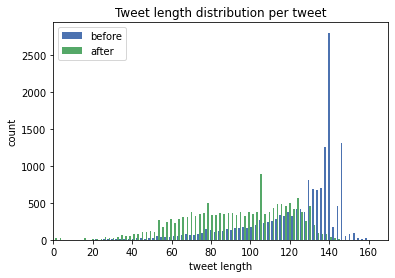

In [ ]:

plt.hist([train['length'], train_processed['length']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

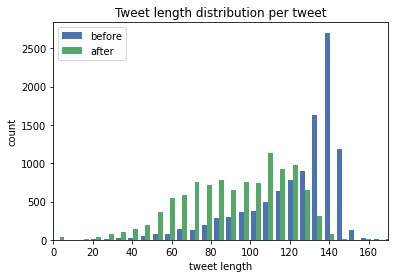

In [ ]:
plt.hist([test['length'], test_processed['length']], bins=100, label=['before', 'after'])
plt.title('Tweet length distribution per tweet')
plt.xlabel('tweet length')
plt.ylabel('count')
plt.legend(loc='upper left')
plt.xlim([0,170])
plt.show()

In [ ]:
# frequency of commonly used words.

# Modelling


## Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the labels and features
X = train_processed['message']
y = train_processed['sentiment']

# Splitting the labels and fetures into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)


In [ ]:
# plot train vs test

## Declare models

In [ ]:
text_cls = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC())])
text_cls.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

## Predicting

In [ ]:
pred = text_cls.predict(X_test)
test_processed

,message,tweetid,length,word_count
0,Europe will now be looking to China to make su...,169760,98,19
1,Combine this with the polling of staffers re c...,35326,107,19
2,The scary unimpeachable evidence that climate ...,224985,69,10
3,Putin got to you too Jill Trump does not ...,476263,98,20
4,RT Female orgasms because global warming Sarc...,872928,62,8
...,...,...,...,...
10541,RT Brb writing a poem about climate change,895714,49,8
10542,2016 the year climate change came home During ...,875167,111,18
10543,RT Pacific countries positive about Fiji lead...,78329,99,14
10544,RT you are so hot you must be the because for...,867455,64,13


In [ ]:
x_unseen = test_processed['message']
y_prediction = text_cls.predict(x_unseen)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
report_1 = print(classification_report(y_test, pred))
report_1

              precision    recall  f1-score   support

          -1       0.61      0.38      0.47       126
           0       0.57      0.40      0.47       224
           1       0.76      0.85      0.81       895
           2       0.73      0.74      0.74       337

    accuracy                           0.73      1582
   macro avg       0.67      0.60      0.62      1582
weighted avg       0.72      0.73      0.72      1582



## Saving the prediction to submit

In [ ]:
Final = test_processed['tweetid']

Final_Table = {'tweetid': Final, 'sentiment':np.round(y_prediction, 0)}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['tweetid', 'sentiment']]


submission.set_index('tweetid')

,sentiment
tweetid,
169760,1
35326,1
224985,1
476263,1
872928,2
...,...
895714,0
875167,1
78329,2


In [ ]:
# Only run this code if wanting to save to a CSV file
# save to .csv file
# submission.to_csv("kaggle_mon.csv",index  = False)

# Model analysis

## Attempt 1
As we can see we scored a weighted f1 score of 0.72, this serves our purpose but we can still try more models and see what works best



## Attempt 2
This time for intreset we will try seeing the score when no pre-processing is done

### Preprocessing

In [ ]:
final_2 = test.set_index('tweetid')

In [ ]:
# Creating the labels and features
X = train['message']
y = train['sentiment']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

### Modeling

In [ ]:
# Creating an object same as last time, and training the model
text_cls_2 = Pipeline([('tfidf',TfidfVectorizer()),('classify',LinearSVC())])
text_cls.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classify',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

### Predicting

In [ ]:
pred_2 = text_cls.predict(X_test)
x_unseen_2 = final_2['message']
y_prediction_2 = text_cls.predict(x_unseen_2)
print(classification_report(y_test, pred_2))

              precision    recall  f1-score   support

          -1       0.67      0.52      0.59       126
           0       0.66      0.42      0.51       224
           1       0.80      0.87      0.83       895
           2       0.76      0.83      0.79       337

    accuracy                           0.77      1582
   macro avg       0.72      0.66      0.68      1582
weighted avg       0.76      0.77      0.76      1582



### Saving and Submitting

In [ ]:
Final_2 = final_2.index 
Final_Table_2 = {'tweetid': Final_2, 'sentiment':np.round(y_prediction, 0)}
submission_2 = pd.DataFrame(data=Final_Table)
submission_2 = submission_2[['tweetid', 'sentiment']]

In [ ]:

submission_2.set_index('tweetid')

,sentiment
tweetid,
169760,1
35326,1
224985,1
476263,1
872928,2
...,...
895714,0
875167,1
78329,2


In [ ]:
# Only run if wanting to save in a csv format!
# submission.to_csv("kaggle.csv",index  = False) #writing csv file

## Evalutation of 2nd attempt
We can see that this went better with a weighted f1 score of 0.75. We used the same model the only difference being the pre-processing, so for our next attempt we will try to tune the pre-processing to be optimal for the model